In [1]:
# Download GloVe embeddings file
#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip glove.6B.zip

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, SpatialDropout1D, LSTM, Dense
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from keras.layers import Bidirectional

Using TensorFlow backend.


In [3]:
# Load the dataset
data = pd.read_csv("train_all_tasks.csv")

In [4]:
data.head()

,rewire_id,text,label_sexist,label_category,label_vector
0,sexism2022_english-7358,"Damn, this writing was pretty chaotic",not sexist,none,none
1,sexism2022_english-2367,"Yeah, and apparently a bunch of misogynistic v...",not sexist,none,none
2,sexism2022_english-3073,How the FUCK is this woman still an MP!!!???,not sexist,none,none
3,sexism2022_english-14895,Understand. Know you're right. At same time I ...,not sexist,none,none
4,sexism2022_english-4118,Surprized they didn't stop and rape some women,not sexist,none,none


In [5]:
# Filter columns for sexism classification
data_sexism = data[['text', 'label_sexist']]

# Filter columns for category classification
data_category = data[['text', 'label_category']]

In [6]:
# Display class distribution
class_sexism = data_sexism['label_sexist'].value_counts(normalize=True)
class_category = data_category['label_category'].value_counts(normalize=True)
print("Class Labe_Sexist:")
print(class_sexism)
print("Class Lable_Category:")
print(class_category)

Class Labe_Sexist:
not sexist    0.757286
sexist        0.242714
Name: label_sexist, dtype: float64
Class Lable_Category:
none                                        0.757286
2. derogation                               0.113571
3. animosity                                0.083214
4. prejudiced discussions                   0.023786
1. threats, plans to harm and incitement    0.022143
Name: label_category, dtype: float64


In [7]:
# Tokenization for sexism classification
max_features = 1000
tokenizer_sexism = Tokenizer(num_words=max_features, split=' ')
tokenizer_sexism.fit_on_texts(data_sexism['text'].values)
X_sexism = tokenizer_sexism.texts_to_sequences(data_sexism['text'].values)
X_sexism = pad_sequences(X_sexism)

In [8]:
# Tokenization for category classification
tokenizer_category = Tokenizer(num_words=max_features, split=' ')
tokenizer_category.fit_on_texts(data_category['text'].values)
X_category = tokenizer_category.texts_to_sequences(data_category['text'].values)
X_category = pad_sequences(X_category)

In [9]:
# Encoding labels for sexism classification
label_encoder_sexism = LabelEncoder()
data_sexism['label_sexist_encoded'] = label_encoder_sexism.fit_transform(data_sexism['label_sexist'])
Y_sexism = pd.get_dummies(data_sexism['label_sexist_encoded']).values


C:\Users\Arnab\.conda\envs\new\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
# Encoding labels for category classification
label_encoder_category = LabelEncoder()
data_category['label_category_encoded'] = label_encoder_category.fit_transform(data_category['label_category'])
Y_category = pd.get_dummies(data_category['label_category_encoded']).values

C:\Users\Arnab\.conda\envs\new\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [11]:
# Load GloVe embeddings
embedding_dim = 100
embedding_index = {}
with open('glove.6B.100d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

In [12]:
# Create embedding matrix for sexism classification
word_index_sexism = tokenizer_sexism.word_index
num_words_sexism = min(max_features, len(word_index_sexism) + 1)
embedding_matrix_sexism = np.zeros((num_words_sexism, embedding_dim))
for word, i in word_index_sexism.items():
    if i < max_features:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix_sexism[i] = embedding_vector

In [13]:
# Create embedding matrix for category classification
word_index_category = tokenizer_category.word_index
num_words_category = min(max_features, len(word_index_category) + 1)
embedding_matrix_category = np.zeros((num_words_category, embedding_dim))
for word, i in word_index_category.items():
    if i < max_features:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix_category[i] = embedding_vector

In [14]:
# Split the dataset into training and testing sets for sexism classification
X_train_sexism, X_test_sexism, Y_train_sexism, Y_test_sexism = train_test_split(X_sexism, Y_sexism, test_size=0.2, random_state=42)

# Split the dataset into training and testing sets for category classification
X_train_category, X_test_category, Y_train_category, Y_test_category = train_test_split(X_category, Y_category, test_size=0.2, random_state=42)

In [15]:
# Define and train the LSTM model for sexism classification using TensorFlow Keras
model_sexism = Sequential()
model_sexism.add(Embedding(input_dim=max_features, output_dim=embedding_dim, input_length=X_sexism.shape[1], weights=[embedding_matrix_sexism], trainable=False))
model_sexism.add(SpatialDropout1D(0.4))
model_sexism.add(Bidirectional(LSTM(196, dropout=0.2, recurrent_dropout=0.2)))
model_sexism.add(Dense(2, activation='softmax'))
model_sexism.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [16]:
# Model summary for sexism classification
model_sexism.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 51, 100)           100000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 51, 100)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 392)               465696    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 786       
Total params: 566,482
Trainable params: 466,482
Non-trainable params: 100,000
_________________________________________________________________


In [17]:
# Define and train the LSTM model for category classification using TensorFlow Keras
model_category = Sequential()
model_category.add(Embedding(input_dim=max_features, output_dim=embedding_dim, input_length=X_category.shape[1], weights=[embedding_matrix_category], trainable=False))
model_category.add(SpatialDropout1D(0.4))
model_category.add(Bidirectional(LSTM(196, dropout=0.2, recurrent_dropout=0.2)))
model_category.add(Dense(5, activation='softmax'))  # 5 classes
model_category.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  # categorical crossentropy for multiclass classification

In [18]:
# Model summary for category classification
model_category.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 51, 100)           100000    
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 51, 100)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 392)               465696    
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 1965      
Total params: 567,661
Trainable params: 467,661
Non-trainable params: 100,000
_________________________________________________________________


In [19]:
# Define the parameter
epochs = 10
batch_size = 64

In [20]:
# Train model for sexism classification
history_sexism = model_sexism.fit(X_train_sexism, Y_train_sexism, validation_data=(X_test_sexism, Y_test_sexism), epochs=epochs, batch_size=batch_size, verbose=2)

Train on 11200 samples, validate on 2800 samples
Epoch 1/10
 - 29s - loss: 0.5477 - accuracy: 0.7580 - val_loss: 0.5332 - val_accuracy: 0.7511
Epoch 2/10
 - 29s - loss: 0.5218 - accuracy: 0.7646 - val_loss: 0.5046 - val_accuracy: 0.7654
Epoch 3/10
 - 30s - loss: 0.4945 - accuracy: 0.7746 - val_loss: 0.4599 - val_accuracy: 0.8032
Epoch 4/10
 - 28s - loss: 0.4585 - accuracy: 0.8008 - val_loss: 0.4573 - val_accuracy: 0.8125
Epoch 5/10
 - 30s - loss: 0.4435 - accuracy: 0.8118 - val_loss: 0.4351 - val_accuracy: 0.8075
Epoch 6/10
 - 27s - loss: 0.4321 - accuracy: 0.8172 - val_loss: 0.4364 - val_accuracy: 0.8182
Epoch 7/10
 - 27s - loss: 0.4243 - accuracy: 0.8208 - val_loss: 0.4292 - val_accuracy: 0.8196
Epoch 8/10
 - 27s - loss: 0.4198 - accuracy: 0.8238 - val_loss: 0.4289 - val_accuracy: 0.8171
Epoch 9/10
 - 27s - loss: 0.4123 - accuracy: 0.8276 - val_loss: 0.4361 - val_accuracy: 0.8218
Epoch 10/10
 - 29s - loss: 0.4085 - accuracy: 0.8285 - val_loss: 0.4319 - val_accuracy: 0.8111


In [21]:
# Train model for category classification
history_category = model_category.fit(X_train_category, Y_train_category, validation_data=(X_test_category, Y_test_category), epochs=epochs, batch_size=batch_size, verbose=2)

Train on 11200 samples, validate on 2800 samples
Epoch 1/10
 - 28s - loss: 0.8468 - accuracy: 0.7562 - val_loss: 0.8345 - val_accuracy: 0.7486
Epoch 2/10
 - 29s - loss: 0.8088 - accuracy: 0.7597 - val_loss: 0.8122 - val_accuracy: 0.7486
Epoch 3/10
 - 28s - loss: 0.7748 - accuracy: 0.7603 - val_loss: 0.7757 - val_accuracy: 0.7500
Epoch 4/10
 - 29s - loss: 0.7307 - accuracy: 0.7687 - val_loss: 0.7486 - val_accuracy: 0.7632
Epoch 5/10
 - 28s - loss: 0.7019 - accuracy: 0.7776 - val_loss: 0.7238 - val_accuracy: 0.7739
Epoch 6/10
 - 27s - loss: 0.6932 - accuracy: 0.7812 - val_loss: 0.7108 - val_accuracy: 0.7761
Epoch 7/10
 - 28s - loss: 0.6878 - accuracy: 0.7826 - val_loss: 0.7036 - val_accuracy: 0.7811
Epoch 8/10
 - 28s - loss: 0.6740 - accuracy: 0.7862 - val_loss: 0.6991 - val_accuracy: 0.7821
Epoch 9/10
 - 29s - loss: 0.6687 - accuracy: 0.7898 - val_loss: 0.7084 - val_accuracy: 0.7825
Epoch 10/10
 - 28s - loss: 0.6610 - accuracy: 0.7891 - val_loss: 0.6967 - val_accuracy: 0.7814


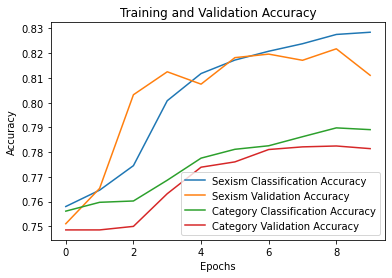

In [22]:
# Plot training and validation accuracy
plt.plot(history_sexism.history['accuracy'], label='Sexism Classification Accuracy')
plt.plot(history_sexism.history['val_accuracy'], label='Sexism Validation Accuracy')
plt.plot(history_category.history['accuracy'], label='Category Classification Accuracy')
plt.plot(history_category.history['val_accuracy'], label='Category Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [28]:
# Evaluate sexism classification model
loss_sexism, accuracy_sexism = model_sexism.evaluate(X_test_sexism, Y_test_sexism, verbose=0)

# Evaluate category classification model
loss_category, accuracy_category = model_category.evaluate(X_test_category, Y_test_category, verbose=0)

# Evaluate sexism classification model
accuracy_sexism_percent = accuracy_sexism * 100
print("Sexism Classification Accuracy: {:.2f}%".format(accuracy_sexism_percent))

# Evaluate category classification model
accuracy_category_percent = accuracy_category * 100
print("Category Classification Accuracy: {:.2f}%".format(accuracy_category_percent))

Sexism Classification Accuracy: 81.11%
Category Classification Accuracy: 78.14%


In [30]:
print("Sexism Classification loss: {:.2f}%".format(loss_sexism))
print("Category Classification loss: {:.2f}%".format(loss_category))

Sexism Classification loss: 0.43%
Category Classification loss: 0.70%


In [26]:
# Take input from user and predict class for both tasks
user_input = input("Enter text: ")
sequence = tokenizer_sexism.texts_to_sequences([user_input])
sequence = pad_sequences(sequence, maxlen=X_sexism.shape[1])
pred_sexism = model_sexism.predict_classes(sequence)[0]
pred_category = model_category.predict_classes(sequence)[0]

print("Predicted Sexism Class:", label_encoder_sexism.inverse_transform([pred_sexism])[0])
print("Predicted Category Class:", label_encoder_category.inverse_transform([pred_category])[0])

Enter text: Is that Ronald's wife?
Predicted Sexism Class: not sexist
Predicted Category Class: none
